# Full Simulation
This tutorial covers how one can use all previous tutorial steps to:
- Create random orientation angles
- Create random defocus values following experimental data distribution
- Generate the clean signal from a pdb file
- Create random noise that with real and frequency domains found in the experimental data
- Add the correct amount of modulated noise as a function of the defocus (SNR)
- Generate small simulations
- Generate large-scale efficient simulations

## Load libraries

In [1]:
import sys
import numpy as np

from pathlib import Path
sys.path.append(str(Path.cwd()) + "/../src")

import EMCrafter
from EMCrafter.sim import ParticleSimulator
from EMCrafter.sampler import OrientationSampler, DefocusSampler
EMCrafter.base._set_logging(minimal=True)

## 1. Initialize Simulator class

ParticleSimulator initialized
SignalGenerator initialized
Environment set to: miniconda3/envs/emcraft/bin/python
Setting number of CPUs to: 1
NoiseGenerator initialized
NoiseShaper initialized
Setting shape to Gaussian
NoiseModulator initialized
SNR initialized


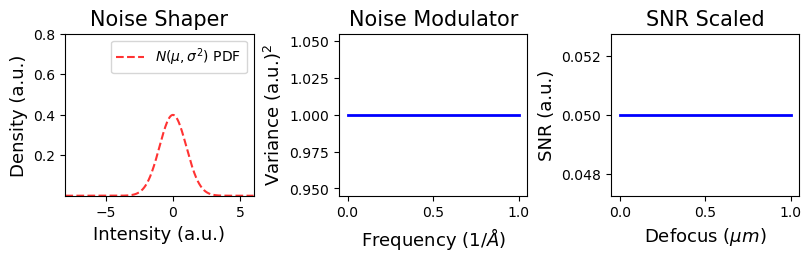

In [2]:
# General parameters
n_cpus = 10                        # Number of CPUs for parallelization
apix = 0.732                       # Resolution (A/pixel)
box_size = 480                     # Image size
image_shape = (box_size, box_size) # Image shape

# Instantiate Simulator
pSimulator = ParticleSimulator(verbose=2)

# In default initialization:
# - Noise Shape: Gaussian
# - Noise Modulation: Flat (no modulation)
# - SNR: Flat (0.05)
pSimulator.info()

## 2. Load customized features

Loaded SignalGenerator object from data/pickle/signal_generator.pkl
Loaded NoiseGenerator object from data/pickle/noise_generator.pkl
Loaded SNR object from data/pickle/snr.pkl


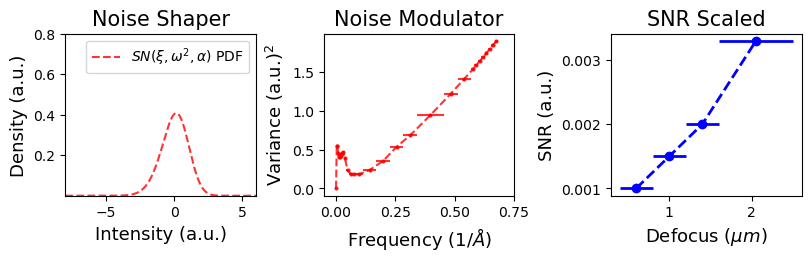

In [3]:
# Load classes
pSimulator.signal = pSimulator.signal.load("data/pickle/signal_generator.pkl")
pSimulator.noise  = pSimulator.noise.load("data/pickle/noise_generator.pkl")
pSimulator.snr    = pSimulator.snr.load("data/pickle/snr.pkl")

# So, now:
# - Noise Shape: Skew-Normal from experimental data
# - Noise Modulation: Frequency dependence from experimental data
# - SNR: SNR as a funciton of defocus from experimental data
pSimulator.info()

## 3. Simulating a single example

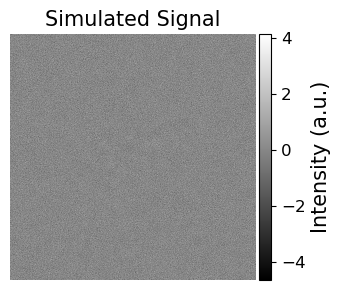

In [4]:
# Set parameters
alt, az, phi = 75, -35, 75  # Orientation
defocus = 10000             # Defocus

# Simulate
p, pmask = pSimulator.simulate(alt, az, phi, defocus)

# For ease of use
sgen = pSimulator.signal
ngen = pSimulator.noise

# Visualize
fig = sgen.plot(p)

## 4. Load our Angle and Defocus sampler

In [5]:
# Load our angle and defocus samplers
osamp = OrientationSampler().load("data/pickle/orientation_sampler.pkl")
dsamp = DefocusSampler().load("data/pickle/defocus_sampler.pkl", validate=False)

# Generate a sample for 5 particles
n_particles = 5
angles  = osamp.sample(n_particles)
defocus = dsamp.sample(n_particles)

Loaded OrientationSampler object from data/pickle/orientation_sampler.pkl
Loaded DefocusSampler object from data/pickle/defocus_sampler.pkl


## 5. Quickly simulate N particles on memory

Starting 'simulate_dataset'...
> Sim. Signal: 100%|#####################| 5.00/5.00 [00:04<00:00, 1.10 image/s]
> Sim. Noise (vectorized)...
> Adding noise (vectorized)...
> Normalizing (vectorized)...
SimResults initialized
Finished 'simulate_dataset' in 4.68s.


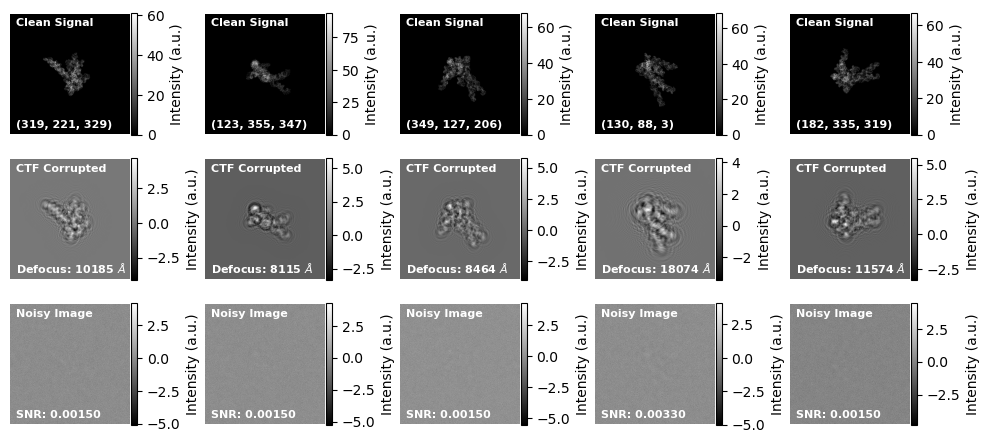

Saving SimResults object  to  data/pickle/dataset_quick.pkl


In [6]:
# The quick simulation keep the particles on memory for inspection and checking
# if everything seems fine, regarding particles projection, ctf corruption
# and the addition of noise, but it is limited to a maximum of 100 particles
sim = pSimulator.simulate_dataset(angles, defocus, quick=True)

# We can plot the result of the simulation for inspection:
_ = sim.plot()

# If you save the this particular simulation you will also save the
# particle images, since they are on memory:
sim.save("data/pickle/dataset_quick.pkl")

## 6. Large-scale simulation

For a large-scale simulation (thousands/millions of particles) we can use a parallelized setup
It may be better to switch into more than 1 job depending on the simulation size, such as submit
multiple slurm jobs. The SimResults class can easily merge results from different places if needed.

In [7]:
# Setup
n_particles = 100   # Number of particles to simulate in this example
n_cpus = 10         # Number of CPUs for parallel computing
chunk_size = 10     # Since this is a small example with only 1000 particles, we
                    # set the chunk size to 10, but for really large-scale simulations
                    # set it to 100-200. This is the number of sim particles per batch

# Load orientation and defocus samplers
osamp = OrientationSampler().load("data/pickle/orientation_sampler.pkl")
dsamp = DefocusSampler().load("data/pickle/defocus_sampler.pkl", validate=False)

# Sample
angles  = osamp.sample(n_particles)
defocus = dsamp.sample(n_particles)

# Simulate
sim = pSimulator.simulate_dataset(
    angles,                       # Sampled orientations
    defocus,                      # Sampled defocus
    n_cpus=n_cpus,                # Parallelization
    chunk_size=chunk_size,        # Number of simulated particles per job
    output="data/sim_particles",  # Output directory
    intermediates=True            # To be more efficient, set intermediates to FALSE. If set
)                                 # to TRUE, this will write files for the simulated clean
                                  # signal, CTF corrupted and the final noise addition. In
                                  # this example, for plotting purposes, we set it to True

Loaded OrientationSampler object from data/pickle/orientation_sampler.pkl
Loaded DefocusSampler object from data/pickle/defocus_sampler.pkl
Starting 'simulate_dataset'...
Simulating 100 particles distributed in 10 chunks of size 10...
Simulating: 100%|███████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]
SimResults initialized
Finished 'simulate_dataset' in 32.32s.


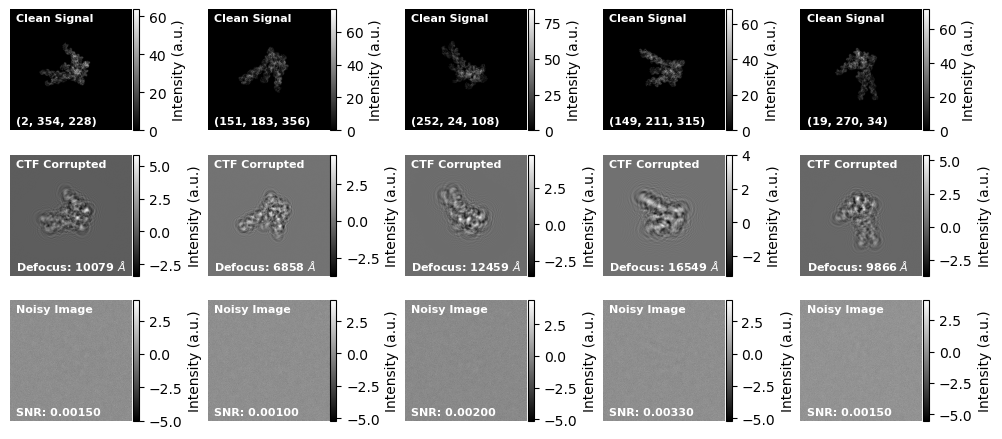

In [8]:
# Visualization
fig = sim.plot()

In [9]:
# The 'sim' variable carries a SimResults class, which contains all metadata
# associated with the simulated particles. One can quickly run over the
# particles array if needed:
sim.particles[0]

{'angle': array([319.47348811,  13.53713181,  76.45343855]),
 'defocus': 18482.888672195782,
 'snr': 0.0033000000000000004,
 'signal': 'data/sim_particles/clean_0.mrcs',
 'corrupted': 'data/sim_particles/corrupted_0.mrcs',
 'noisy': 'data/sim_particles/noisy_0.mrcs',
 'index': 0}

In [10]:
# To save this dataset:
sim.save("data/pickle/dataset_full.pkl")

Saving SimResults object  to  data/pickle/dataset_full.pkl


## Storing/Loading ParticleSimulator

In [11]:
# The particle simulator class can be saved with
pSimulator.save("data/pickle/simulator.pkl")
# And loaded with
pSimulator = ParticleSimulator().load("data/pickle/simulator.pkl")

Saving ParticleSimulator object  to  data/pickle/simulator.pkl
Loaded ParticleSimulator object from data/pickle/simulator.pkl
